In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahulav0210","key":"78b5921c5c9d78a6a6ed346d0a3217fb"}'}

In [6]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
!chmod 600 ~/.kaggle/kaggle.json
# Else retry with fresh API token

In [9]:
!kaggle datasets download -d shreyapmaher/fruits-dataset-images


 93% 190M/205M [00:02<00:00, 85.7MB/s]
100% 205M/205M [00:02<00:00, 95.9MB/s]


In [10]:
!unzip /content/fruits-dataset-images.zip

Archive:  /content/fruits-dataset-images.zip
  inflating: images/apple fruit/Image_1.jpg  
  inflating: images/apple fruit/Image_10.jpg  
  inflating: images/apple fruit/Image_11.jpg  
  inflating: images/apple fruit/Image_12.jpg  
  inflating: images/apple fruit/Image_13.png  
  inflating: images/apple fruit/Image_14.png  
  inflating: images/apple fruit/Image_15.jpg  
  inflating: images/apple fruit/Image_16.jpg  
  inflating: images/apple fruit/Image_17.jpeg  
  inflating: images/apple fruit/Image_18.jpg  
  inflating: images/apple fruit/Image_19.jpg  
  inflating: images/apple fruit/Image_2.jpg  
  inflating: images/apple fruit/Image_20.jpg  
  inflating: images/apple fruit/Image_21.jpg  
  inflating: images/apple fruit/Image_22.jpg  
  inflating: images/apple fruit/Image_23.png  
  inflating: images/apple fruit/Image_24.jpg  
  inflating: images/apple fruit/Image_25.jpg  
  inflating: images/apple fruit/Image_26.jpg  
  inflating: images/apple fruit/Image_27.jpg  
  inflating: ima

In [11]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [12]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [13]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)


In [14]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [15]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0
        self.best_epoch=1   # epoch with the lowest loss
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored

    def on_train_begin(self, logs=None):
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'
        print_in_color (msg, (244, 252, 3), (55,65,80))
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80))
        self.start_time= time.time()

    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))

    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count

    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                color=(0,255,0)
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))
                        self.count=0
                        self.stop_count=0
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial

                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))

In [16]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


In [17]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [18]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80))
    # now create the class_df and convert to csv file
    class_dict=generator.class_indices
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class')
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80))
    return model_save_loc, csv_save_loc

In [19]:
def predictor(sdir, csv_path,  model_path, crop_image = False):
    # read in the csv file
    class_df=pd.read_csv(csv_path)
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)
    scale=class_df['scale by'].iloc[0]
    try:
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list)
    index_list=[]
    prob_list=[]
    cropped_image_list=[]
    good_image_count=0
    for i in range (image_count):
        img=cv2.imread(path_list[i])
        if crop_image == True:
            status, img=crop(img)
        else:
            status=True
        if status== True:
            good_image_count +=1
            img=cv2.resize(img, img_size)
            cropped_image_list.append(img)
            img=img*s2 - s1
            img=np.expand_dims(img, axis=0)
            p= np.squeeze (model.predict(img))
            index=np.argmax(p)
            prob=p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count==1:
        class_name= class_df['class'].iloc[index_list[0]]
        probability= prob_list[0]
        img=cropped_image_list [0]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most=0
    for i in range (len(index_list)-1):
        key= index_list[i]
        keycount=0
        for j in range (i+1, len(index_list)):
            nkey= index_list[j]
            if nkey == key:
                keycount +=1
        if keycount> most:
            most=keycount
            isave=i
    best_index=index_list[isave]
    psum=0
    bestsum=0
    for i in range (len(index_list)):
        psum += prob_list[i]
        if index_list[i]==best_index:
            bestsum += prob_list[i]
    img= cropped_image_list[isave]/255
    class_name=class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    return class_name, bestsum/image_count

In [20]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[]
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

(1749, 1500, 3)


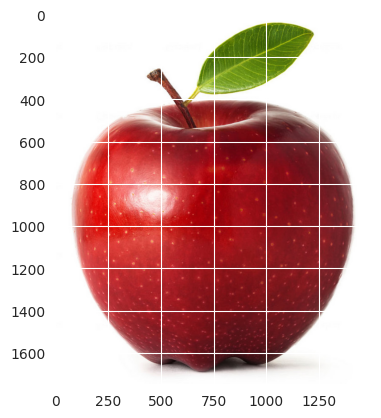

In [21]:
fpath=r'/content/images/apple fruit/Image_1.jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)


In [22]:
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)
    # split df into train_df and test_df
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    return train_df, test_df, valid_df


In [23]:
sdir=r'images'
train_df, test_df, valid_df= preprocess(sdir, .8,.1)

train_df length:  288   test_df length:  36   valid_df length:  36
banana fruit        32
cherry fruit        32
kiwi fruit          32
apple fruit         32
strawberry fruit    32
grapes fruit        32
mango fruit         32
chickoo fruit       32
orange fruit        32
Name: labels, dtype: int64


In [24]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)
    # create and store the augmented images
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    ndf=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
    print (list(ndf['labels'].value_counts()) )
    return ndf

In [25]:
max_samples= 1006
min_samples=0
column='labels'
working_dir = r'./'
img_size=(300, 300)
ndf=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

[32, 32, 32, 32, 32, 32, 32, 32, 32]
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
[1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006]


In [26]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( ndf, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  36   test steps:  1
Found 9054 validated image filenames belonging to 9 classes.
Found 36 validated image filenames belonging to 9 classes.
Found 35 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


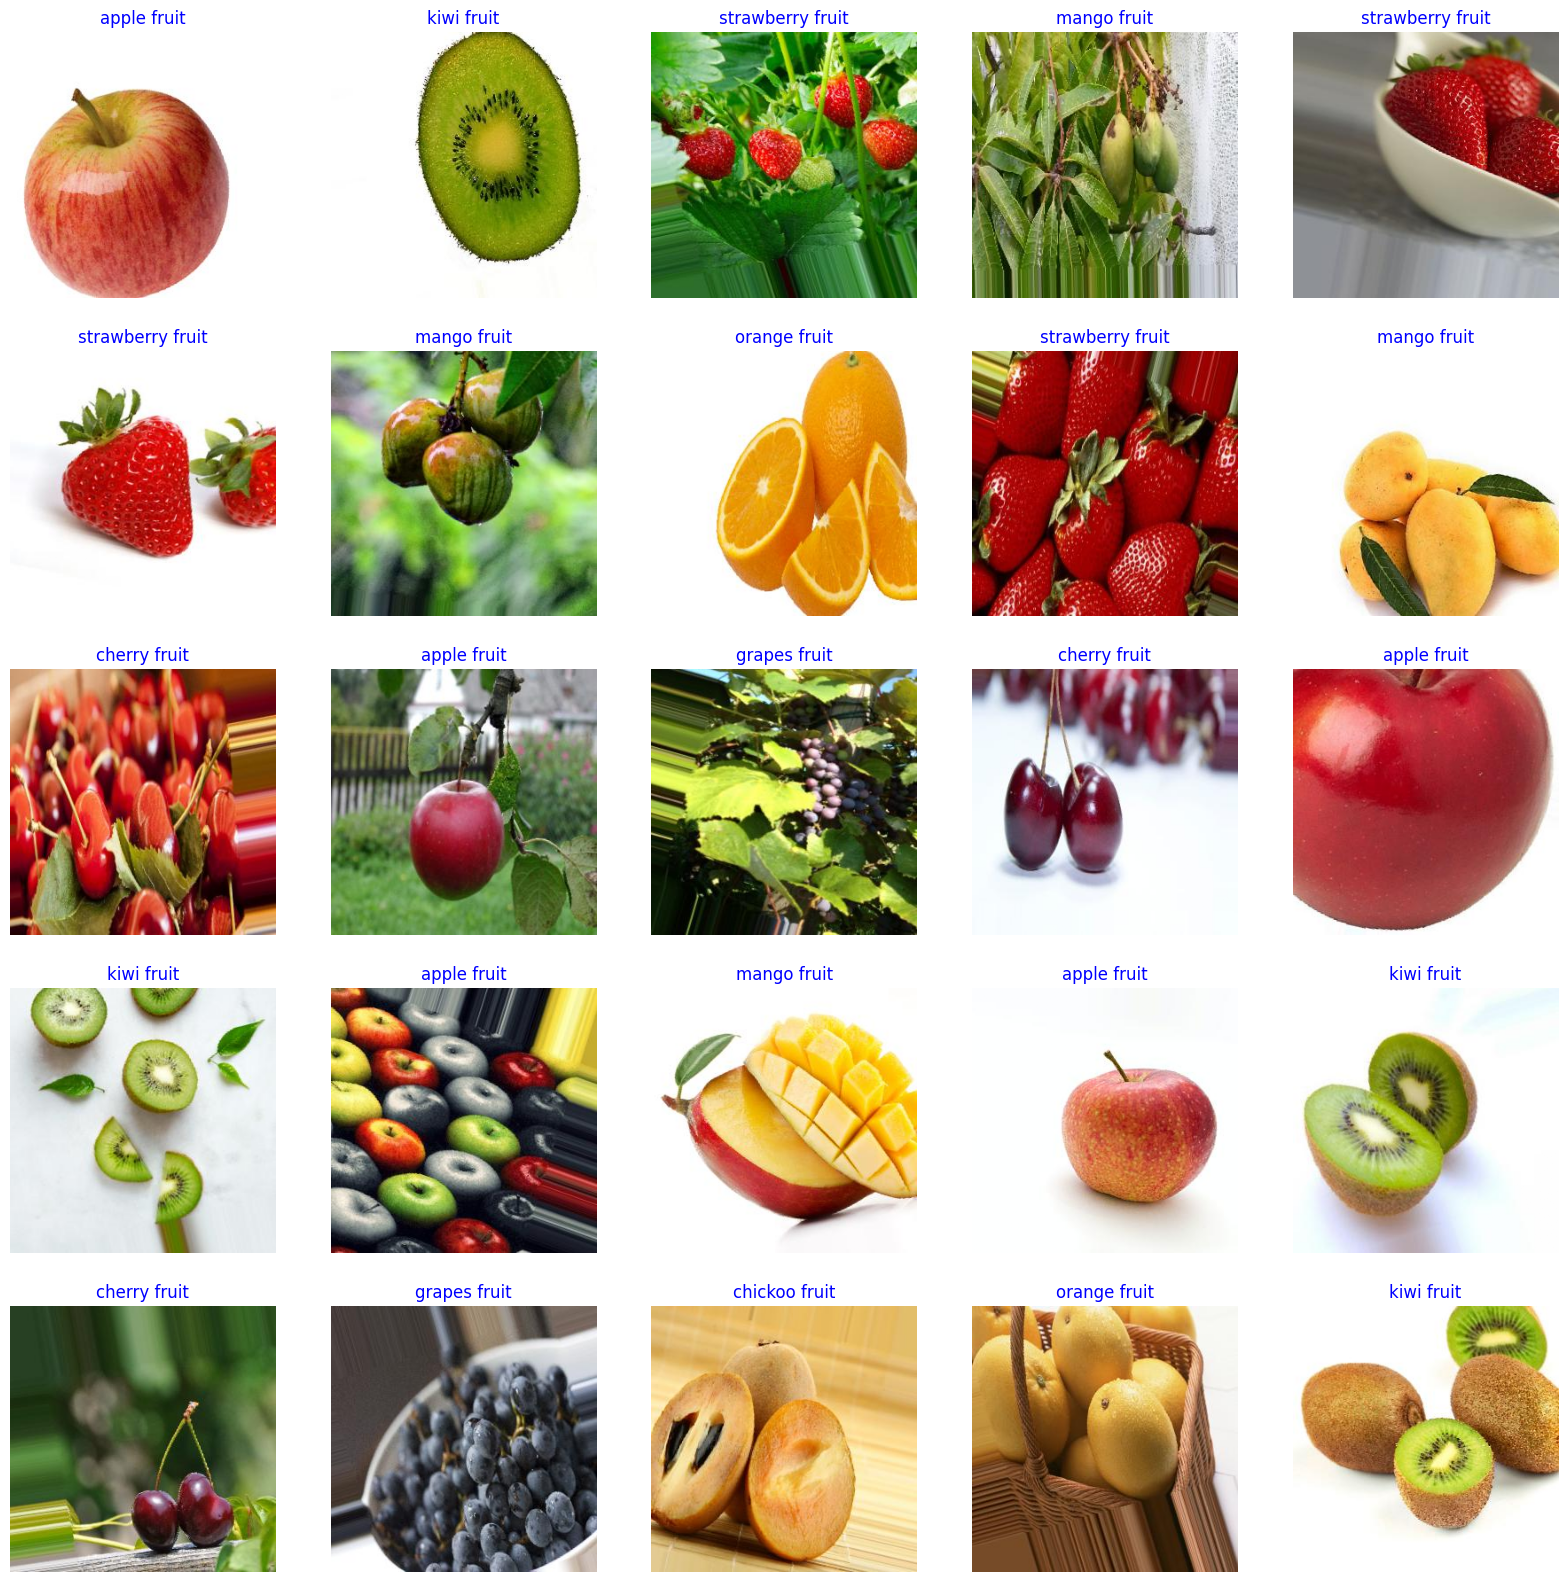

In [27]:
show_image_samples(train_gen)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define your model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_gen,
    epochs=6,
    validation_data=valid_gen,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/6
302/302 [==============================] - 1107s 4s/step - loss: 29.8449 - accuracy: 0.4205 - val_loss: 1.5181 - val_accuracy: 0.4571 - lr: 0.0010
Epoch 2/6
302/302 [==============================] - ETA: 0s - loss: 0.9804 - accuracy: 0.6586
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
302/302 [==============================] - 1108s 4s/step - loss: 0.9804 - accuracy: 0.6586 - val_loss: 1.5523 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 3/6
302/302 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7911
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
302/302 [==============================] - 1107s 4s/step - loss: 0.6043 - accuracy: 0.7911 - val_loss: 1.6134 - val_accuracy: 0.5714 - lr: 5.0000e-04
Epoch 4/6
201/302 [==================>...........] - ETA: 6:09 - loss: 0.4401 - accuracy: 0.8529

In [35]:
# Save the model
model.save("fruitmodel-1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


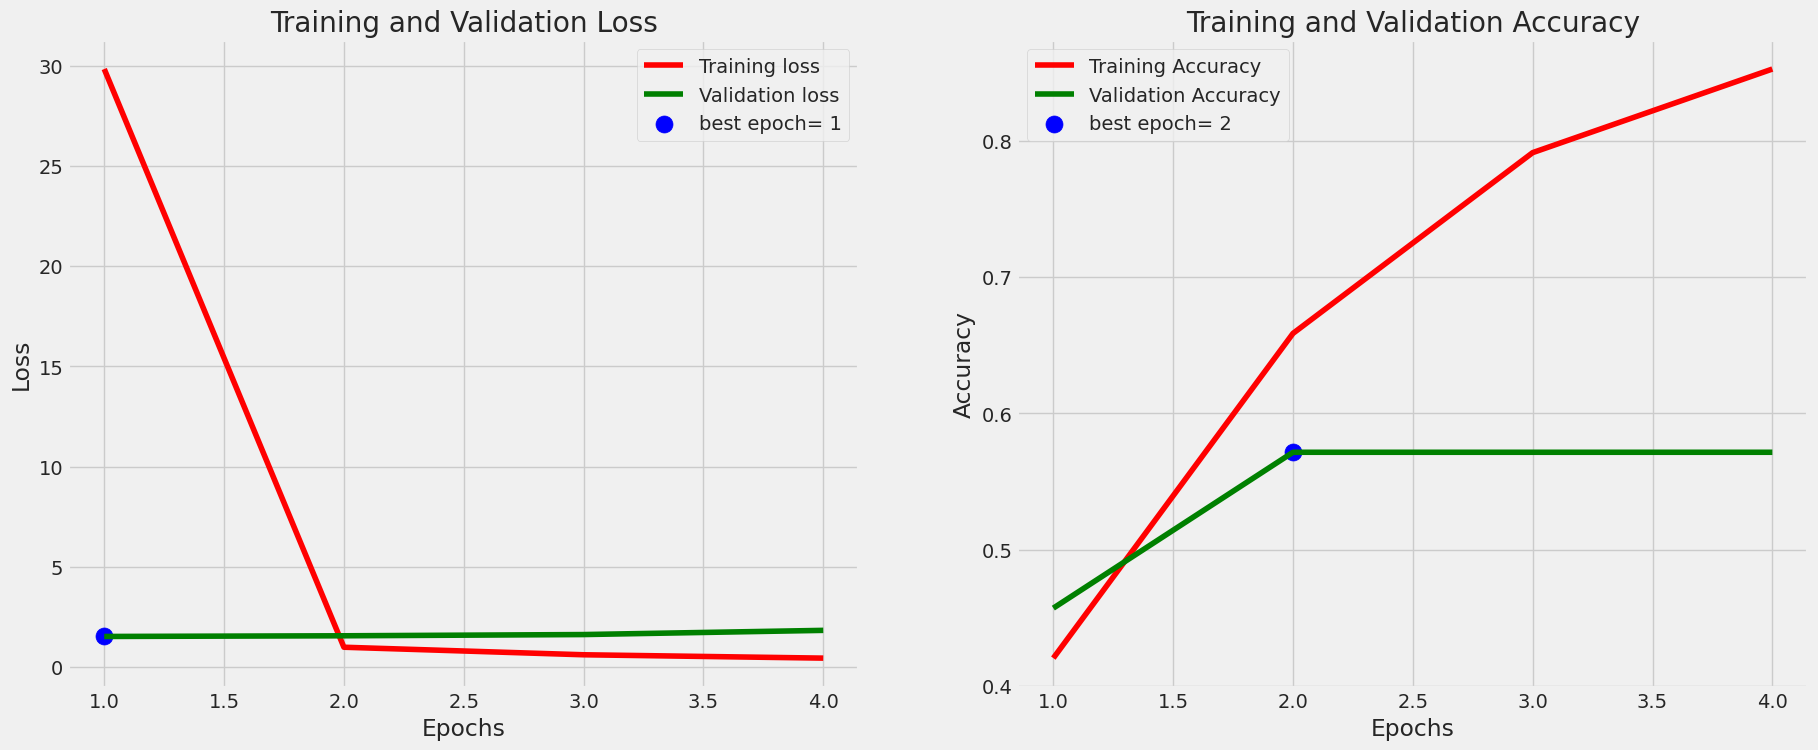

1/1 [==============================] - 4s 4s/step - loss: 1.2875 - accuracy: 0.5556
Accuracy on the test set is 55.56%



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as ./fruitmodel-1.h5-skin disease-55.55.h5

class csv file was saved as ./class_dict.csv



In [37]:
tr_plot(history, 0)
subject = 'skin disease'
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100
msg = f'Accuracy on the test set is {acc:5.2f}%'
print_in_color(msg, (0, 255, 0), (55, 65, 80))
generator = train_gen
scale = 1
model_name = "fruitmodel-1.h5"  # Define the model name
model_save_loc, csv_save_loc = saver(working_dir, model, model_name, subject, acc, img_size, scale, generator)


In [ ]:
print_code=0
preds=model.predict(test_gen, steps=test_steps, verbose=1)
print_info( test_gen, preds, print_code, working_dir, subject )

In [ ]:
!zip /content/EfficientNetB3-skindisease-83.00.h5

In [51]:
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
# input an image of a melanoma
img_path=r'/content/oorange-1.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# model was trained on rgb images so convert image to rgb
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
# check if the directory was created and image stored
print (os.listdir(store_path))

['oorange-1.jpg']


 Model is being loaded- this will take about 10 seconds
1/1 [==============================] - 0s 99ms/step
 image is of class orange fruit with a probability of  82.18 %



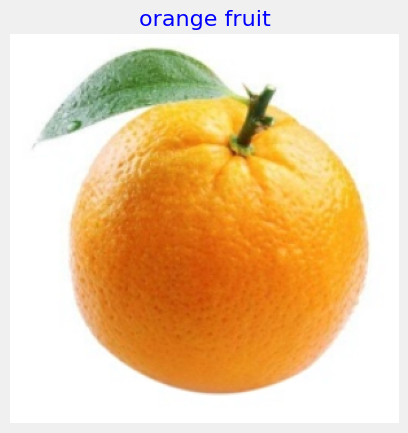

In [61]:
csv_path=csv_save_loc # path to class_dict.csv
model_path=model_save_loc # path to the trained model
model_path="/content/fruitmodel-1.h5"
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False) # run the classifier
msg=f' image is of class {class_name} with a probability of {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

In [66]:
import cv2
import numpy as np
from keras.models import load_model


# Classify fresh/rotten
def print_fresh(res):
    threshold_fresh = 0.10  # set according to standards
    threshold_medium = 0.35  # set according to standards
    if res < threshold_fresh:
        print("The item is FRESH!")
    elif threshold_fresh < res < threshold_medium:
        print("The item is MEDIUM FRESH")
    else:
        print("The item is NOT FRESH")


def pre_proc_img(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)
    img = cv2.resize(img, (100, 100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess the image
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img


def evaluate_rotten_vs_fresh(image_path):
    # Load the trained model
    model = load_model('/content/rottenvsfresh98pval.h5')

    # Read and process and predict
    prediction = model.predict(pre_proc_img(image_path))

    return prediction[0][0]


# Example usage:
img_path = '/content/orange-2.png'
is_rotten = evaluate_rotten_vs_fresh(img_path)
print(f'Prediction: {is_rotten}',print_fresh(is_rotten))

1/1 [==============================] - 1s 624ms/step
The item is NOT FRESH
Prediction: 1.0 None


['Image_11.jpg']
 Model is being loaded- this will take about 10 seconds
1/1 [==============================] - 0s 92ms/step
 image is of class apple fruit with a probability of  94.46 %

1/1 [==============================] - 1s 629ms/step
The item is MEDIUM FRESH
Prediction: 0.3429591953754425 None


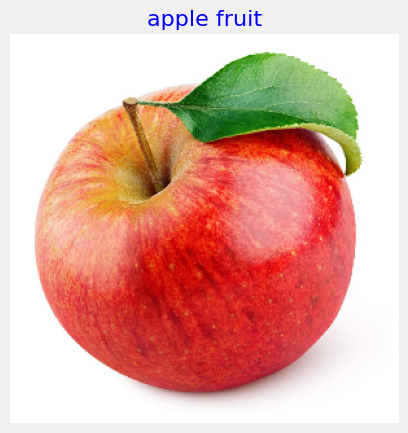

In [71]:
import cv2
import numpy as np
from keras.models import load_model
import os
import shutil

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Failed to load image: {image_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        return img
    except Exception as e:
        print(f"Error occurred while loading and preprocessing image: {e}")
        return None

# Function to classify fresh/rotten
def print_fresh(res):
    threshold_fresh = 0.10  # set according to standards
    threshold_medium = 0.35  # set according to standards
    if res < threshold_fresh:
        print("The item is FRESH!")
    elif threshold_fresh < res < threshold_medium:
        print("The item is MEDIUM FRESH")
    else:
        print("The item is NOT FRESH")

# Function to evaluate freshness
def evaluate_rotten_vs_fresh(image_path):
    try:
        img = load_and_preprocess_image(image_path)
        if img is None:
            return None

        model = load_model('/content/rottenvsfresh98pval.h5')
        prediction = model.predict(img)
        return prediction[0][0]
    except Exception as e:
        print(f"Error occurred while evaluating freshness: {e}")
        return None

# Example usage:

# 1st Cell
# Create storage directory
store_path = os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)

# Copy and preprocess the image
img_path = r'/content/images/apple fruit/Image_11.jpg'
img = cv2.imread(img_path, cv2.IMREAD_REDUCED_COLOR_2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
file_name = os.path.split(img_path)[1]
dst_path = os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
print(os.listdir(store_path))

# 2nd Cell
# Define paths and run the classifier
csv_path = csv_save_loc  # path to class_dict.csv
model_path = model_save_loc  # path to the trained model
model_path = "/content/fruitmodel-1.h5"
class_name, probability = predictor(store_path, csv_path, model_path, crop_image=False)
msg = f' image is of class {class_name} with a probability of {probability * 100: 6.2f} %'
print_in_color(msg, (0, 255, 255), (65, 85, 55))

# 3rd Cell
# Evaluate freshness of the fruit
img_path = '/content/images/apple fruit/Image_11.jpg'  # Adjust the path according to the stored image
is_rotten = evaluate_rotten_vs_fresh(img_path)
if is_rotten is not None:
    print(f'Prediction: {is_rotten}', print_fresh(is_rotten))
else:
    print("Failed to evaluate freshness.")
